In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix, classification_report, hamming_loss, f1_score
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch

In [27]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/anna-
[nltk_data]     alexandradanchenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
RANDOM_SEED = 42

# Import Data

In [30]:
job_level_data = pd.read_csv("../data/JobLevelData_preproc.csv")
classes_labels = ['Chief Officer', 'Director', 'Individual Contributor/Staff', 'Manager',
 'Vice President']
job_level_data

,Title,Label
0,Vice President Director of Systems Engineering,"[0, 0, 0, 0, 1]"
1,Systems Engineer Systems Architect,"[0, 0, 1, 1, 0]"
2,Executive Director Global Informational Techno...,"[1, 1, 0, 0, 0]"
3,Chief Technology Officer Executive Director of...,"[1, 1, 0, 0, 0]"
4,Vice President Chief Information Officer,"[0, 0, 0, 0, 1]"
...,...,...
2221,Net Software Architect and Team Project Lead,"[0, 0, 0, 1, 0]"
2222,Solutions Architect Technical Lead,"[0, 0, 1, 1, 0]"
2223,Manager Salesforcecom Administration and Relea...,"[0, 0, 0, 1, 0]"
2224,Innovation Automation Architect,"[0, 0, 0, 1, 0]"


To establish a baseline model for this multi label text classification task, it was chosen to transform the model to binary classification problem. This involves dividing the problem into 5 binary classification problems, one for each class.

In [31]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])
    return filtered_text

job_level_data["Title"] = job_level_data["Title"].apply(remove_stopwords)

In [32]:
job_level_data["Label"] = job_level_data["Label"].apply(eval)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    job_level_data['Title'],
    pd.DataFrame(job_level_data['Label'].to_list(), columns=classes_labels),
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True
)

In [34]:
tfidf = TfidfVectorizer(ngram_range=(1,3))
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

X_train = pd.DataFrame(X_train.toarray(), columns=tfidf.get_feature_names_out())
X_test = pd.DataFrame(X_test.toarray(), columns=tfidf.get_feature_names_out())

In [35]:
xgb = XGBClassifier(n_estimators=5)
clf = MultiOutputClassifier(xgb)  #convert problem to binary classification
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

hamming_score = (1 - hamming_loss(y_test, y_pred))
f1 = f1_score(y_test, y_pred, average='micro')

print(f'Hamming Score: {hamming_score:.5f}')
print(f'F1 Score (micro): {f1:.5f}')


Hamming Score: 0.95471
F1 Score (micro): 0.89267


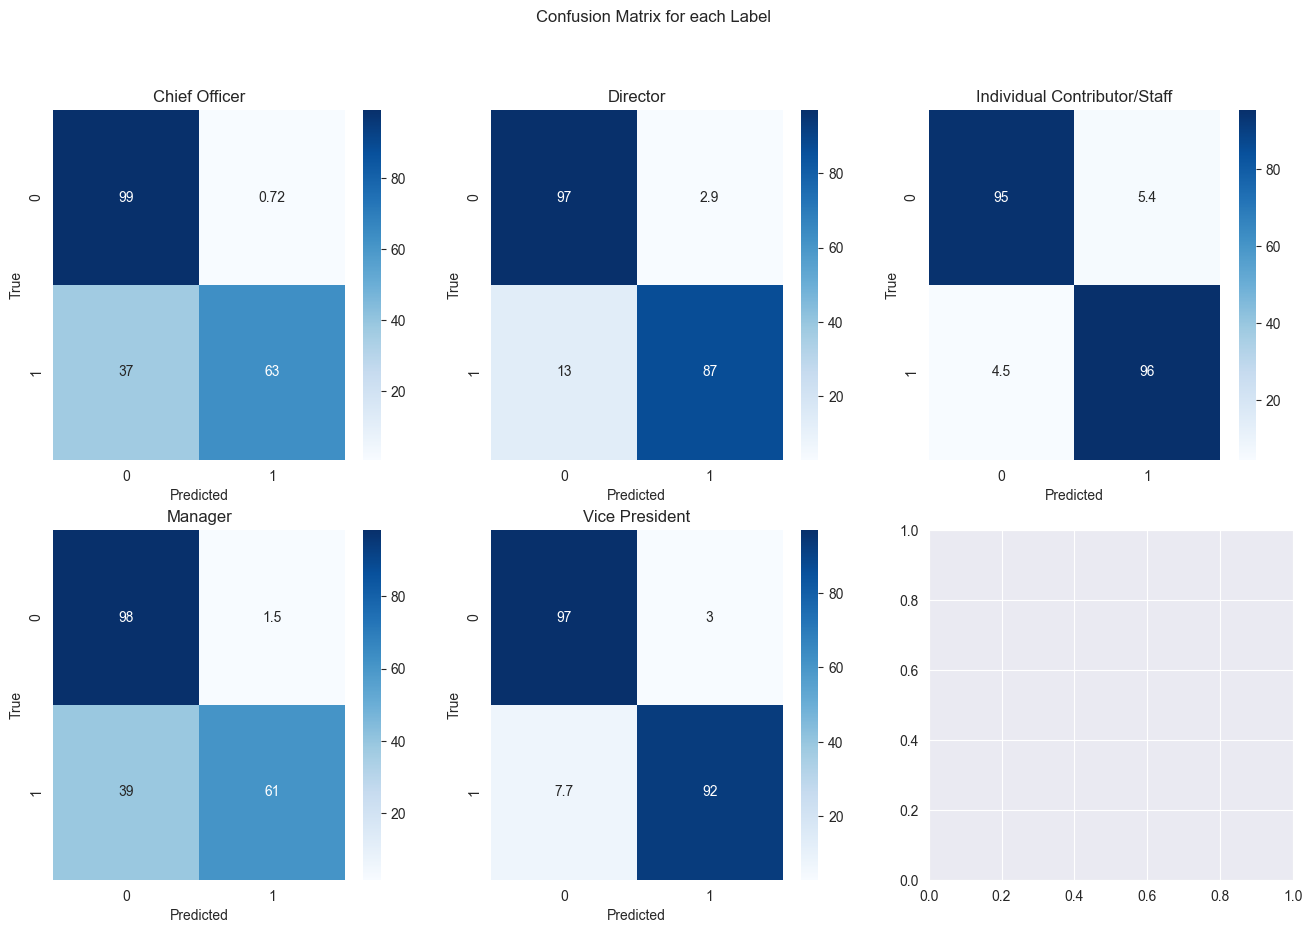

In [36]:
cm = multilabel_confusion_matrix(y_test.values.tolist(), y_pred.tolist())

f, axes = plt.subplots(2, 3, figsize=(16, 10))
f.suptitle("Confusion Matrix for each Label")

for i, matrix in enumerate(cm):
    with np.errstate(invalid='ignore'):
        normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100
        normalized_matrix[np.isnan(normalized_matrix)] = 0 
    ax = axes[i//3, i % 3]
    sns.heatmap(normalized_matrix, annot=True, cmap='Blues', ax = ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(classes_labels[i])
""
plt.show()

In [37]:
report = classification_report(y_pred, y_test, target_names=classes_labels, zero_division=1)
print(report)

                              precision    recall  f1-score   support

               Chief Officer       0.63      0.86      0.73        22
                    Director       0.87      0.89      0.88        95
Individual Contributor/Staff       0.96      0.95      0.95       226
                     Manager       0.61      0.83      0.71        36
              Vice President       0.92      0.87      0.89        83

                   micro avg       0.88      0.91      0.89       462
                   macro avg       0.80      0.88      0.83       462
                weighted avg       0.89      0.91      0.90       462
                 samples avg       0.90      0.92      0.90       462

